# Hermite Interpolation (VC)

In [1]:
Needs["xAct`xCoba`", FileNameJoin[{Environment["GENERATO"], "src/Generato.wl"}]];

------------------------------------------------------------
Package xAct`xPerm`  version 1.2.3, {2015, 8, 23}
CopyRight (C) 2003-2020, Jose M. Martin-Garcia, under the General Public\
 
>   License.
Connecting to external mac executable...
Connection established.
------------------------------------------------------------
Package xAct`xTensor`  version 1.2.0, {2021, 10, 17}
CopyRight (C) 2002-2021, Jose M. Martin-Garcia, under the General Public\
 
>   License.
------------------------------------------------------------
These packages come with ABSOLUTELY NO WARRANTY; for details type\
 
>   Disclaimer[]. This is free software, and you are welcome to redistribute\
 
>   it under certain conditions. See the General Public License for details.
------------------------------------------------------------
------------------------------------------------------------
Package xAct`xCoba`  version 0.8.6, {2021, 2, 28}
CopyRight (C) 2005-2021, David Yllanes and Jose M. Martin-Garcia, under t

A polynomial of degree $K$, denoted $H(x)$, used to approximate a function $f(x)$ can be written as:
$$H(x) = \sum_{i=0}^{K} c_i x^i.$$
Determining the $K+1$ coefficients, $c_i$, requires $K+1$ equations. The Hermite method imposes the following conditions, assuming $K$ is odd, at two nodes (e.g., $x=0$ and $x=1$):
$$
\begin{align*}
H(0) &= f(0), & H(1) &= f(1) \\
H'(0) &= f'(0), & H'(1) &= f'(1) \\
&\vdots & &\vdots \\
\frac{d^{(K-1)/2}}{dx^{(K-1)/2}}H(0) &= \frac{d^{(K-1)/2}}{dx^{(K-1)/2}}f(0), &
\frac{d^{(K-1)/2}}{dx^{(K-1)/2}}H(1) &= \frac{d^{(K-1)/2}}{dx^{(K-1)/2}}f(1)
\end{align*}
$$
In this context, $x=0$ and $x=1$ might be the coordinates of two coarse-grid nodes nearest to a fine-grid point, such as $x=1/2$, where a value is being interpolated.

The derivatives of the function, $\frac{d^i f}{dx^i}$, must be approximated using a finite difference method that uses neighboring grid points. To achieve consistent accuracy, a finite difference formula of at least order $K+1$ may be needed.

This contrasts with Lagrangian interpolation, which requires only $K+1$ grid points (function values) to construct a polynomial of degree $K$.

## Finite Difference

In [2]:
(**
 * solFD returns the coefficients of 'fdOrd'-th finite difference,
 * which is 'accuracyOrd'-th order accurate.
 *)
solFD[fdOrd_, accuracyOrd_] := Module[{stencils},
    stencils = GetCenteringStencils[accuracyOrd];
    GetFiniteDifferenceCoefficients[stencils, fdOrd]
];

For example

1                2                          2                1
c   -> --      c   -> -(-)    c  -> 0        c  -> -        c  -> -(--)
 -2    12       -1      3      0              1    3         2      12

         1            4               5            4                1
c   -> -(--)   c   -> -       c  -> -(-)     c  -> -        c  -> -(--)
 -2      12     -1    3        0      2       1    3         2      12
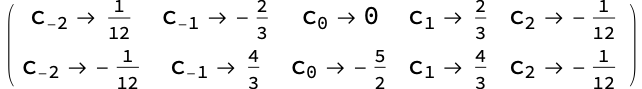

In [4]:
{solFD[1, 4], solFD[2, 4]} // MatrixForm

## Sampling Values and Sampling Derivatives

In [5]:
(**
 * Function values at grid index i
 *)
(*s[i_] := ToExpression["s" <> If[i == 0, "", If[i > 0, "p", "m"]] <> ToString[Abs[i]]];*)
s[i_] := Subscript[f, i];

For example

f
 -1

f
 0

f
 1
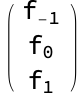

In [8]:
{s[-1], s[0], s[1]} // MatrixForm

$$
df(i)=\sum_{j=-(K+1)/2}^{(K+1)/2}c_js_{j+i}.
$$
Note here $df$ represents a derivative. The specific order of derivative is determined by the choice of coefficients $c_j$.

In [9]:
(**
 * Derivatives of grid function expressed using neighboring grid function values
 *)
ds[i_, accuracyOrd_] := Module[{i0 = Quotient[accuracyOrd, 2]}, Sum[Subscript[c, j] s[i + j], {j, -i0, i0}]];

For example

c   f   + c   f   + c  f   + c  f  + c  f
 -2  -3    -1  -2    0  -1    1  0    2  1

c   f   + c   f   + c  f  + c  f  + c  f
 -2  -2    -1  -1    0  0    1  1    2  2

c   f   + c   f  + c  f  + c  f  + c  f
 -2  -1    -1  0    0  1    1  2    2  3
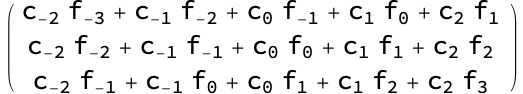

In [11]:
{ds[-1, 4], ds[0, 4], ds[1, 4]} // MatrixForm

## Hermite Interpolation

In [12]:
H[x_, ord_] = Sum[Subscript[h, i] x^i, {i, 0, ord}];

2       3
h  + x h  + x  h  + x  h
 0      1       2       3
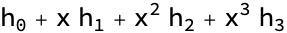

In [13]:
H[x, 3]

In [14]:
HermiteInterp[x0_, ord_] := Module[{eqs, i0, fdaccuracy},
    i0 = (ord - 1) / 2;
    fdaccuracy = ord + 1;
    eqs = Flatten@Table[{(D[H[x, ord], {x, fdord}] /. {x -> i}) == (ds[i, fdaccuracy] /. solFD[fdord, fdaccuracy])}, {fdord, 0, i0}, {i, 0, 1}];
    hs = Table[Subscript[h, i], {i, 0, ord}];
    Return[
        (H[x, ord] /. Solve[eqs, hs][[1]] // FullSimplify) /. {x -> x0} // Simplify
    ]
];

f  + f
 0    1
-------
   2
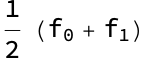

In [15]:
HermiteInterp[1/2, 1]

f   - 9 f   + 56 f  + 56 f  - 9 f  + f
 -2      -1       0       1      2    3
---------------------------------------
                  96
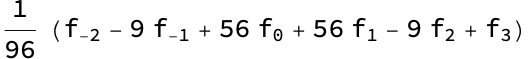

In [16]:
HermiteInterp[1/2, 3]

-28 f   + 275 f   - 1377 f   + 6890 f  + 6890 f  - 1377 f  + 275 f  - 28 f
     -3        -2         -1         0         1         2        3       4
---------------------------------------------------------------------------
                                   11520
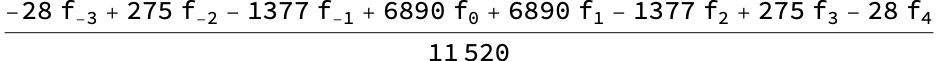

In [17]:
HermiteInterp[1/2, 5]

(689 f   - 7973 f   + 44650 f   - 173642 f   + 781396 f  + 781396 f  - 173642 f  + 
      -4         -3          -2           -1           0           1           2
 
>     44650 f  - 7973 f  + 689 f ) / 1290240
             3         4        5
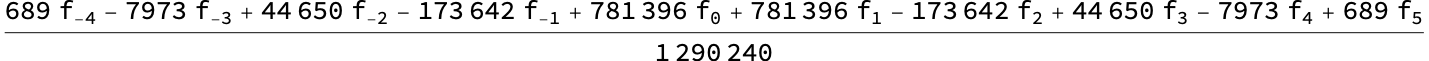

In [18]:
HermiteInterp[1/2, 7]